In [1]:
# Impor library yang diperlukan
import numpy as np  # NumPy untuk operasi numerik
import tensorflow_datasets as tfds  # TensorFlow Datasets untuk mengakses dataset
import tensorflow as tf  # TensorFlow untuk operasi deep learning

# Nonaktifkan progress bar untuk TensorFlow Datasets untuk mengurangi kekacauan pada konsol
tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt  # Impor library untuk membuat grafik

def plot_graphs(history, metric):

#   Membuat grafik untuk memvisualisasikan metrik pelatihan dan validasi selama epoch.
#   Parameter:
#   - history: Riwayat pelatihan yang diperoleh dari pelatihan model.
#   - metric: Metrik yang akan divisualisasikan (contoh: 'accuracy', 'loss').


# Plot metrik pelatihan
  plt.plot(history.history[metric])

# Plot metrik validasi dengan garis gaya berbeda
  plt.plot(history.history['val_'+metric], '')

# Atur label untuk sumbu-sumbu
  plt.xlabel("Epochs")
  plt.ylabel(metric)

# Tambahkan legenda untuk membedakan antara metrik pelatihan dan validasi
  plt.legend([metric, 'val_'+metric])


In [3]:
# Memuat dataset 'imdb_reviews' dari TensorFlow Datasets bersama dengan informasi tambahan
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi bagian pelatihan dan pengujian
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dari dataset pelatihan
train_dataset.element_spec


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# Mengambil satu contoh data dari dataset pelatihan
for example, label in train_dataset.take(1):
  # Menampilkan teks dari contoh dalam bentuk numpy array
  print('text: ', example.numpy())

  # Menampilkan label dari contoh dalam bentuk numpy array
  print('label: ', label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
# Ukuran buffer untuk pengacakan dataset
BUFFER_SIZE = 10000

# Ukuran batch untuk pelatihan dan pengujian
BATCH_SIZE = 64

# Melakukan pengacakan, pembagian batch, dan prefetching pada dataset pelatihan
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Melakukan pembagian batch dan prefetching pada dataset pengujian
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch dari dataset pelatihan untuk ditampilkan
for example, label in train_dataset.take(1):
  # Menampilkan tiga teks pertama dari batch
  print('texts: ', example.numpy()[:3])
  print()

  # Menampilkan tiga label pertama dari batch
  print('labels: ', label.numpy()[:3])


texts:  [b'I looked over the other comments and was thoroughly amused to find that clearly only people who actually worked on the movie had commented. I mean, I hate to say bad things about an amateur production, but if you make a bad movie and want to comment on it, tone it down a little. "Groundbreaking" is a little over the top. This is a Boston based college production that doesn\'t even achieve the level of most amateur college film. It\'s what you would expect a bunch of kids to do. A silly action film without much creativity. It\'s pretty funny if you\'re willing to poke fun at it. Not something you will ever see unless you are a student at Emerson college.'
 b'As a South African, it\'s an insult to think that someone was actually paid to produce this nonsense!<br /><br />Despite the fact that the director was one of the writers for the original Shaka Zulu mini, this "addition" to the series is appalling! The original series was based on historical facts about a man who was a gr

In [6]:
# Ukuran vocabulari yang akan digunakan
VOCAB_SIZE = 1000

# Membuat layer TextVectorization menggunakan TensorFlow Keras
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Menyesuaikan layer dengan dataset pelatihan untuk membangun vocabulari
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# Mendapatkan vocabulari dari layer TextVectorization
vocab = np.array(encoder.get_vocabulary())

# Menampilkan 20 token pertama dari vocabulari
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
# Menggunakan layer TextVectorization (encoder) untuk mengkodekan tiga contoh teks pertama dari dataset pelatihan
encoded_example = encoder(example)[:3].numpy()

# Menampilkan hasil pengkodean teks
encoded_example

array([[ 10, 581, 126, ...,   0,   0,   0],
       [ 15,   4,   1, ...,   0,   0,   0],
       [  2, 198,  18, ...,   0,   0,   0]])

In [9]:
# Iterasi sebanyak tiga kali untuk menampilkan contoh asli, hasil pengkodean, dan pengembalian hasil pengkodean
for n in range(3):
  # Menampilkan teks asli dari contoh
  print("Original: ", example[n].numpy())

  # Menampilkan teks hasil pengkodean yang dikembalikan ke bentuk token menggunakan vocabulari
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()


Original:  b'I looked over the other comments and was thoroughly amused to find that clearly only people who actually worked on the movie had commented. I mean, I hate to say bad things about an amateur production, but if you make a bad movie and want to comment on it, tone it down a little. "Groundbreaking" is a little over the top. This is a Boston based college production that doesn\'t even achieve the level of most amateur college film. It\'s what you would expect a bunch of kids to do. A silly action film without much creativity. It\'s pretty funny if you\'re willing to poke fun at it. Not something you will ever see unless you are a student at Emerson college.'
Round-trip:  i looked over the other comments and was [UNK] [UNK] to find that clearly only people who actually worked on the movie had [UNK] i mean i hate to say bad things about an [UNK] production but if you make a bad movie and want to comment on it [UNK] it down a little [UNK] is a little over the top this is a [UNK] 

In [10]:
# Membangun model sequential menggunakan TensorFlow Keras
model = tf.keras.Sequential([
    # Layer TextVectorization (encoder) untuk mengubah teks menjadi urutan token
    encoder,

    # Layer Embedding untuk mengonversi token menjadi vektor embedding
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Jumlah token dalam vocabulari
        output_dim=64,  # Dimensi vektor embedding
        mask_zero=True),  # Menggunakan masking untuk menangani panjang urutan yang bervariasi

    # Layer Bidirectional LSTM untuk memproses urutan secara simultan maju dan mundur
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Layer Dense dengan aktivasi ReLU untuk ekstraksi fitur
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dense dengan satu neuron tanpa aktivasi untuk output biner (misalnya, sentimen positif/negatif)
    tf.keras.layers.Dense(1)
])

In [11]:
# Menampilkan informasi apakah setiap layer dalam model mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# Memprediksi sentimen pada satu contoh teks tanpa padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Menggunakan model untuk melakukan prediksi pada contoh teks
predictions = model.predict(np.array([sample_text]))

# Menampilkan hasil prediksi
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01048437]


In [13]:
# Memprediksi sentimen pada satu contoh teks dengan padding
padding = "the " * 2000  # Membuat string padding dengan panjang 2000 token
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Menggunakan model untuk melakukan prediksi pada contoh teks dengan padding
predictions = model.predict(np.array([sample_text, padding]))

# Menampilkan hasil prediksi
print(predictions[0])

1/1 [==============================] - 0s 86ms/step
[0.01048437]


In [14]:
# Mengompilasi model dengan konfigurasi fungsi kerugian, optimizer, dan metrik evaluasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Fungsi kerugian binary crossentropy untuk tugas klasifikasi biner
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Metrik evaluasi yang akan dimonitor selama pelatihan, dalam hal ini akurasi
)

In [15]:
# Melakukan pelatihan model dengan dataset pelatihan, dan memonitor performa pada dataset pengujian
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoch atau iterasi pelatihan
    validation_data=test_dataset,  # Dataset pengujian untuk memonitor performa selama pelatihan
    validation_steps=30  # Jumlah langkah validasi yang akan diambil selama setiap epoch
)

Epoch 1/10
391/391 [==============================] - 53s 109ms/step - loss: 0.6384 - accuracy: 0.5752 - val_loss: 0.4719 - val_accuracy: 0.7750
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3894 - accuracy: 0.8211 - val_loss: 0.3566 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3346 - accuracy: 0.8520 - val_loss: 0.3325 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3176 - accuracy: 0.8638 - val_loss: 0.3556 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3134 - accuracy: 0.8633 - val_loss: 0.3220 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3098 - accuracy: 0.8655 - val_loss: 0.3348 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3041 - accuracy: 0.8695 - val_loss: 0.3255 - val_accuracy

In [16]:
# Evaluasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Menampilkan hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3146 - accuracy: 0.8567
Test Loss: 0.3145749270915985
Test Accuracy: 0.8566799759864807


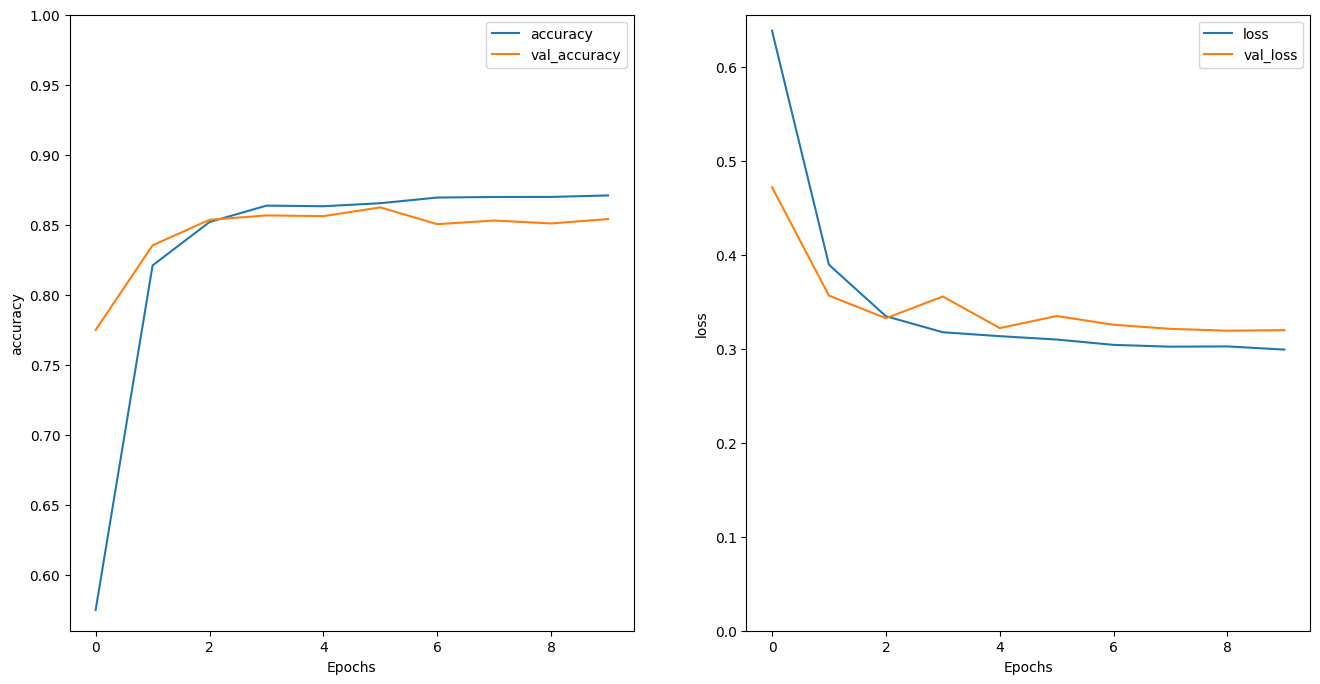

In [17]:
# Menampilkan dua subplot: satu untuk grafik akurasi dan satu untuk grafik loss
plt.figure(figsize=(16, 8))

# Subplot pertama untuk grafik akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)  # Mengatur batas sumbu y antara 0 dan 1 untuk akurasi

# Subplot kedua untuk grafik loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)  # Mengatur batas sumbu y mulai dari 0 untuk loss

# Menampilkan grafik
plt.show()

In [18]:
# Memprediksi sentimen pada satu contoh teks menggunakan model yang telah dilatih
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Menggunakan model untuk melakukan prediksi pada contoh teks
predictions = model.predict(np.array([sample_text]))

# Menampilkan hasil prediksi
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.58775973]


In [19]:
# Membuat model sequential dengan struktur yang baru
model = tf.keras.Sequential([
    # Layer TextVectorization (encoder) untuk mengubah teks menjadi urutan token
    encoder,

    # Layer Embedding untuk mengonversi token menjadi vektor embedding
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Jumlah token dalam vocabulari
        output_dim=64,  # Dimensi vektor embedding
        mask_zero=True),  # Menggunakan masking untuk menangani panjang urutan yang bervariasi

    # Layer Bidirectional LSTM untuk memproses urutan secara simultan maju dan mundur
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Layer Bidirectional LSTM kedua dengan panjang urutan yang dijaga
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Layer Dense dengan aktivasi ReLU untuk ekstraksi fitur
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),

    # Layer Dense dengan satu neuron tanpa aktivasi untuk output biner
    tf.keras.layers.Dense(1)
])

In [20]:
# Mengompilasi model dengan konfigurasi fungsi kerugian, optimizer, dan metrik evaluasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Fungsi kerugian binary crossentropy untuk tugas klasifikasi biner
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Metrik evaluasi yang akan dimonitor selama pelatihan, dalam hal ini akurasi
)

In [21]:
# Melakukan pelatihan model dengan dataset pelatihan, dan memonitor performa pada dataset pengujian
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoch atau iterasi pelatihan
    validation_data=test_dataset,  # Dataset pengujian untuk memonitor performa selama pelatihan
    validation_steps=30  # Jumlah langkah validasi yang akan diambil selama setiap epoch
)


Epoch 1/10
391/391 [==============================] - 80s 153ms/step - loss: 0.6350 - accuracy: 0.5752 - val_loss: 0.4533 - val_accuracy: 0.7781
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3865 - accuracy: 0.8293 - val_loss: 0.3619 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3363 - accuracy: 0.8562 - val_loss: 0.3370 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3187 - accuracy: 0.8641 - val_loss: 0.3380 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3143 - accuracy: 0.8666 - val_loss: 0.3441 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3043 - accuracy: 0.8686 - val_loss: 0.3249 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.2993 - accuracy: 0.8730 - val_loss: 0.3178 - val_ac

In [22]:
# Evaluasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Menampilkan hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 19s 49ms/step - loss: 0.3256 - accuracy: 0.8587
Test Loss: 0.3255511224269867
Test Accuracy: 0.8587200045585632


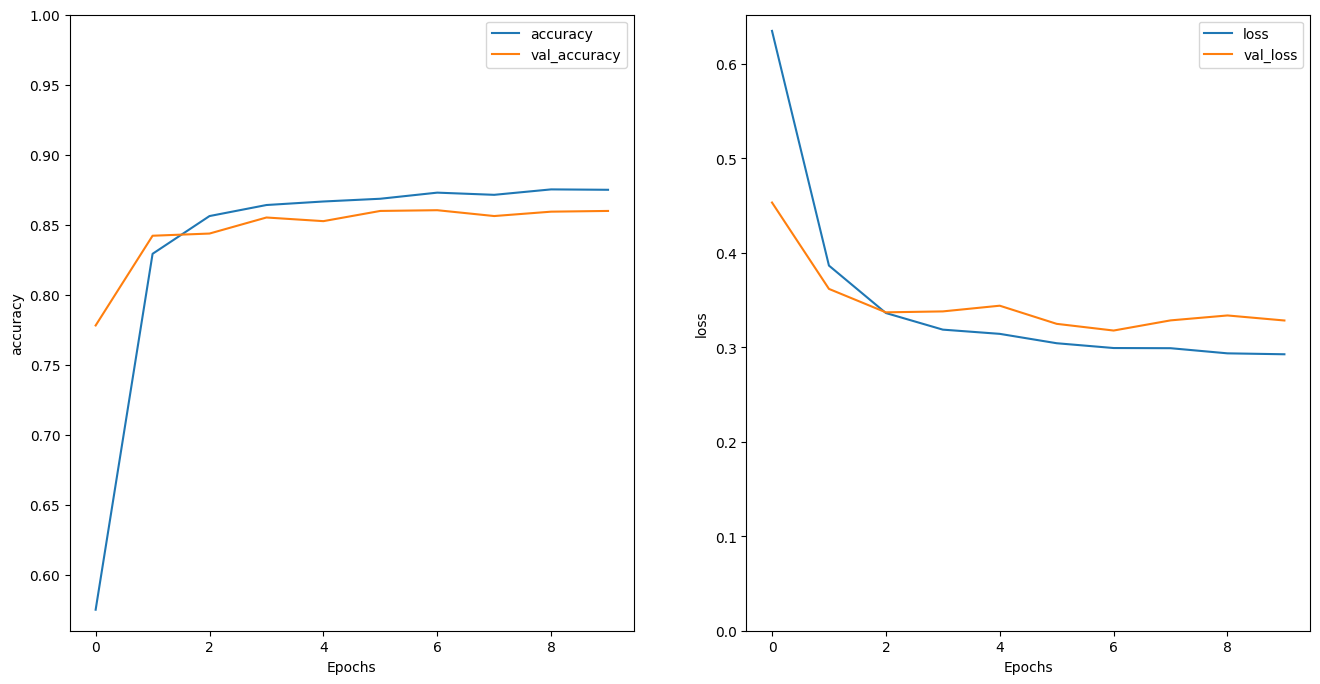

In [23]:
# Menampilkan dua subplot: satu untuk grafik akurasi dan satu untuk grafik loss
plt.figure(figsize=(16, 8))

# Subplot pertama untuk grafik akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)  # Mengatur batas sumbu y antara 0 dan 1 untuk akurasi

# Subplot kedua untuk grafik loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)  # Mengatur batas sumbu y mulai dari 0 untuk loss

# Menampilkan grafik
plt.show()


In [24]:
# Memprediksi sentimen pada satu contoh teks menggunakan model yang telah dilatih
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Menggunakan model untuk melakukan prediksi pada contoh teks
predictions = model.predict(np.array([sample_text]))

# Menampilkan hasil prediksi
print(predictions[0])


1/1 [==============================] - 7s 7s/step
[0.2997105]


In [25]:
# Membuat model sequential dengan struktur yang baru
model = tf.keras.Sequential([
    # Layer TextVectorization (encoder) untuk mengubah teks menjadi urutan token
    encoder,

    # Layer Embedding untuk mengonversi token menjadi vektor embedding
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Jumlah token dalam vocabulari
        output_dim=64,  # Dimensi vektor embedding
        mask_zero=True),  # Menggunakan masking untuk menangani panjang urutan yang bervariasi

    # Layer Bidirectional LSTM untuk memproses urutan secara simultan maju dan mundur
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Layer Bidirectional LSTM kedua dengan panjang urutan yang dijaga
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Layer Dense dengan aktivasi ReLU untuk ekstraksi fitur
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),

    # Layer Dense dengan satu neuron tanpa aktivasi untuk output biner
    tf.keras.layers.Dense(1)
])


In [26]:
# Mengompilasi model dengan konfigurasi fungsi kerugian, optimizer, dan metrik evaluasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Fungsi kerugian binary crossentropy untuk tugas klasifikasi biner
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Metrik evaluasi yang akan dimonitor selama pelatihan, dalam hal ini akurasi
)


In [27]:
# Melakukan pelatihan model dengan dataset pelatihan, dan memonitor performa pada dataset pengujian
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoch atau iterasi pelatihan
    validation_data=test_dataset,  # Dataset pengujian untuk memonitor performa selama pelatihan
    validation_steps=30  # Jumlah langkah validasi yang akan diambil selama setiap epoch
)


Epoch 1/10
391/391 [==============================] - 78s 154ms/step - loss: 0.6299 - accuracy: 0.5802 - val_loss: 0.4370 - val_accuracy: 0.7969
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3834 - accuracy: 0.8310 - val_loss: 0.3509 - val_accuracy: 0.8562
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3360 - accuracy: 0.8540 - val_loss: 0.3292 - val_accuracy: 0.8625
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3156 - accuracy: 0.8634 - val_loss: 0.3323 - val_accuracy: 0.8438
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3124 - accuracy: 0.8661 - val_loss: 0.3195 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3066 - accuracy: 0.8671 - val_loss: 0.3273 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3030 - accuracy: 0.8695 - val_loss: 0.3238 - val_ac

In [28]:
# Evaluasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Menampilkan hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 20s 52ms/step - loss: 0.3286 - accuracy: 0.8557
Test Loss: 0.3286106586456299
Test Accuracy: 0.855679988861084


In [29]:
# Memprediksi sentimen pada satu contoh teks tanpa padding
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Menggunakan model untuk melakukan prediksi pada contoh teks
predictions = model.predict(np.array([sample_text]))

# Menampilkan hasil prediksi
print(predictions)


1/1 [==============================] - 6s 6s/step
[[-1.9553337]]


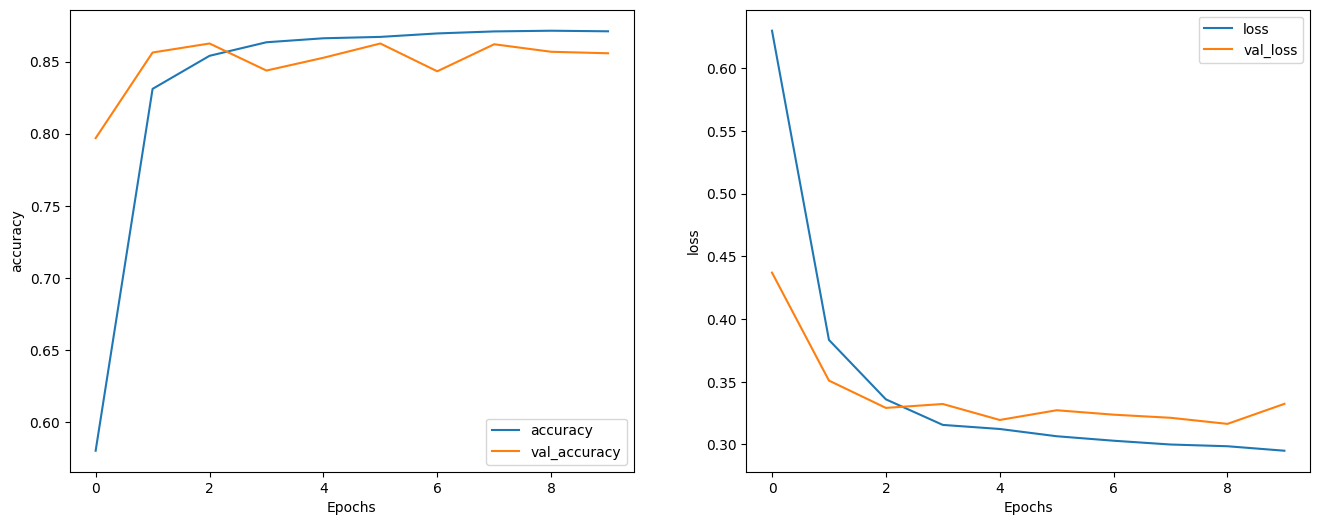

In [30]:
# Menampilkan dua subplot: satu untuk grafik akurasi dan satu untuk grafik loss
plt.figure(figsize=(16, 6))

# Subplot pertama untuk grafik akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

# Subplot kedua untuk grafik loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Menampilkan grafik
plt.show()
